# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

C:\Users\andre\Anaconda3\lib\site-packages\pandas\util\_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [7]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [12]:
# Check for NaN values.

df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
customer_name    324 non-null object
offer_id         324 non-null int64
n                324 non-null int64
dtypes: int64(2), object(1)
memory usage: 7.7+ KB


In [13]:
# Check of transaction counts - all are 1. No zeros or negatives.

df_transactions['n'].value_counts()

1    324
Name: n, dtype: int64

In [14]:
# Check to ensure that numbers make sense.

df_transactions['offer_id'].value_counts()

30    22
22    21
8     20
7     19
29    17
31    17
26    15
18    14
11    13
4     12
6     12
24    12
9     10
1     10
2     10
14     9
27     9
17     7
10     7
3      6
15     6
13     6
25     6
28     6
20     6
16     5
12     5
19     5
23     5
5      4
21     4
32     4
Name: offer_id, dtype: int64

In [15]:
#Review of number of orders by each customer.

pd.set_option('display.max_rows', 500)
df_transactions['customer_name'].value_counts()

Sanders       9
Sanchez       7
Fisher        7
Miller        7
Young         6
Thomas        6
Morales       6
Harris        6
Peterson      6
Rogers        6
Foster        5
Butler        5
Jackson       5
Hughes        5
Lopez         5
James         5
Lee           5
Parker        5
Nelson        4
Perry         4
Hill          4
Diaz          4
Gutierrez     4
Price         4
King          4
Barnes        4
Cox           4
Baker         4
White         4
Brooks        4
Clark         4
Carter        4
Bell          4
Turner        4
Kelly         4
Wright        4
Taylor        4
Thompson      4
Wood          4
Gomez         4
Cooper        4
Stewart       3
Long          3
Martin        3
Johnson       3
Adams         3
Sullivan      3
Campbell      3
Richardson    3
Lewis         3
Martinez      3
Williams      3
Brown         3
Morris        3
Gray          3
Davis         3
Howard        3
Scott         3
Cook          2
Murphy        2
Smith         2
Mitchell      2
Robinson

In [19]:
# Number of customer names.

counter = df_transactions['customer_name'].unique()
counter.size

100

In [20]:
# Check for NaN values.

df_offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
offer_id     32 non-null int64
campaign     32 non-null object
varietal     32 non-null object
min_qty      32 non-null int64
discount     32 non-null int64
origin       32 non-null object
past_peak    32 non-null bool
dtypes: bool(1), int64(3), object(3)
memory usage: 1.6+ KB


In [21]:
# Each offer_id is only used once as expected.

df_offers['offer_id'].value_counts()

32    1
31    1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
1     1
Name: offer_id, dtype: int64

In [13]:
# Review of campaign.

df_offers['campaign'].value_counts()

August       3
June         3
December     3
March        3
July         3
May          3
October      3
February     3
November     2
September    2
April        2
January      2
Name: campaign, dtype: int64

In [14]:
# Review of varietal.

df_offers['varietal'].value_counts()

Champagne             7
Cabernet Sauvignon    6
Pinot Noir            4
Prosecco              4
Espumante             3
Merlot                3
Malbec                2
Chardonnay            2
Pinot Grigio          1
Name: varietal, dtype: int64

In [15]:
# Review of min_qty.

df_offers['min_qty'].value_counts()

72     14
144     7
6       7
12      4
Name: min_qty, dtype: int64

In [16]:
# Review of discount.

df_offers['discount'].value_counts()

56    2
50    2
45    2
88    2
83    2
63    1
32    1
66    1
17    1
82    1
19    1
85    1
86    1
87    1
89    1
39    1
34    1
59    1
40    1
43    1
44    1
47    1
48    1
52    1
54    1
57    1
64    1
Name: discount, dtype: int64

In [17]:
# Review of origin.

df_offers['origin'].value_counts()

France          9
Chile           4
Italy           3
Oregon          3
Australia       3
California      3
Germany         3
New Zealand     2
South Africa    2
Name: origin, dtype: int64

In [18]:
# Review of past_peak.

df_offers['past_peak'].value_counts()

False    25
True      7
Name: past_peak, dtype: int64

In [19]:
# As per the visual checks performed on the previous lines using .info(), .isna().sum() and .value_counts(), there are no NaN,
# blanks, 0's, negative numbers or other data that does not make sense in either of the data frames. The data is "clean" 

In [22]:
# Creation of the working dataframe.

df_trans_pivot=pd.pivot_table(df_transactions,index='customer_name', columns='offer_id')
df_trans_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, Adams to Young
Data columns (total 32 columns):
(n, 1)     10 non-null float64
(n, 2)     10 non-null float64
(n, 3)     6 non-null float64
(n, 4)     12 non-null float64
(n, 5)     4 non-null float64
(n, 6)     12 non-null float64
(n, 7)     19 non-null float64
(n, 8)     20 non-null float64
(n, 9)     10 non-null float64
(n, 10)    7 non-null float64
(n, 11)    13 non-null float64
(n, 12)    5 non-null float64
(n, 13)    6 non-null float64
(n, 14)    9 non-null float64
(n, 15)    6 non-null float64
(n, 16)    5 non-null float64
(n, 17)    7 non-null float64
(n, 18)    14 non-null float64
(n, 19)    5 non-null float64
(n, 20)    6 non-null float64
(n, 21)    4 non-null float64
(n, 22)    21 non-null float64
(n, 23)    5 non-null float64
(n, 24)    12 non-null float64
(n, 25)    6 non-null float64
(n, 26)    15 non-null float64
(n, 27)    9 non-null float64
(n, 28)    6 non-null float64
(n, 29)    17 non-null float64
(n, 30)    

In [23]:
# Change NaN values to zeros.

df_trans_pivot = df_trans_pivot.fillna(value=0,axis=0)

In [24]:
# confirms that all values are 0 or 1.

pd.set_option('display.max_columns', 50)
df_trans_pivot.apply(pd.Series.value_counts)

n                                                                  \
offer_id  1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17   
0.0       90  90  94  88  96  88  81  80  90  93  87  95  94  91  94  95  93   
1.0       10  10   6  12   4  12  19  20  10   7  13   5   6   9   6   5   7   

                                                                      
offer_id  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  
0.0       86  95  94  96  79  95  88  94  85  91  94  83  78  83  96  
1.0       14   5   6   4  21   5  12   6  15   9   6  17  22  17   4

In [25]:
# Final visual check of output format

df_trans_pivot.head()

n                                                         \
offer_id        1    2    3    4    5    6    7    8    9    10   11   12   
customer_name                                                               
Adams          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Allen          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
Anderson       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Bailey         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
Baker          0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0   

                                                                           \
offer_id        13   14   15   16   17   18   19   20   21   22   23   24   
customer_name                                                               
Adams          0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
Allen          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Anderson       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
Bailey         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Baker          0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   

                                                       
offer_id        25   26   27   28   29   30   31   32  
customer_name                                          
Adams          0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  
Allen          0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
Anderson       0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
Bailey         0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
Baker          0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [26]:
# What values of SS do you believe represent better clusterings? Why? 

# Lower values of SS indicate smaller squared distances between the points in a cluster and the cluster centroid.
# However, the SS number doesn't specify the distances between the centroids of the clusters.
# The SS number decreases as the number of clusters increases. 
# The distance between cluster centroids will decrease as the number of clusters applied to a dataset increases.
# A SS number for a value of K that suddenly decreases very nominally on the next K value is the better clustering
# as it lowers SS without lowering the distances between centroids too much.


In [27]:
# creation of matrix and comparison of shape to original dataframe

x_cols = df_trans_pivot.as_matrix()
x_cols = np.nan_to_num(x_cols)
print(x_cols.shape)
print(df_trans_pivot.shape)
numoforders=sum(sum(x_cols))
print(numoforders)

(100, 32)
(100, 32)
324.0


C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


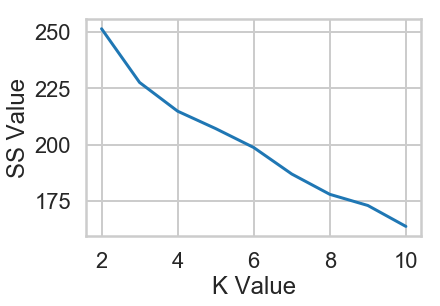

In [28]:
from sklearn.cluster import KMeans

k = [2,3,4,5,6,7,8,9,10]
SS = np.zeros(shape=(9,1))

for i,b in enumerate(k):
    kmeans = KMeans(n_clusters=b, random_state=0).fit(x_cols)
    SS[i] = kmeans.inertia_
    
plt.plot(k,SS)
plt.xlabel('K Value')
plt.ylabel('SS Value')
plt.show()    

[0 1 2]
[48 16 36]


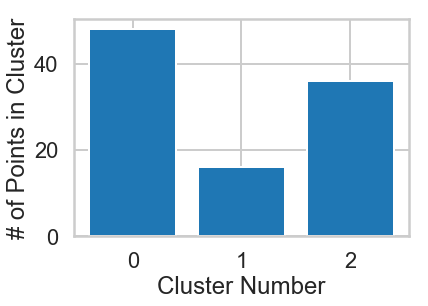

In [29]:
# As per the graph above k = 3 appear to be the point at which the rate of decrease in SS value starts to descend
# much more slowly.

kmeans = KMeans(n_clusters=3, random_state=0).fit(x_cols)
indexc=kmeans.predict(x_cols)
xval = np.unique(indexc)
print(xval)
yval = np.bincount(indexc)
print(yval)
plt.bar(xval,yval)
plt.xlabel('Cluster Number')
plt.ylabel('# of Points in Cluster')
plt.show()

In [30]:
# The challenge experienced when picking K using the elbow method is choosing the point at which the SS value starts to descend
# much more slowly. With this dataset, it is clear that such point is K=3. But it may be harder to select K in datasets where 
# the slope of the SS vs. K plot doesn't have such a clear change in slope.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.09174871508750351
For n_clusters = 3 The average silhouette_score is : 0.12101628521627421
For n_clusters = 4 The average silhouette_score is : 0.13421536289944658
For n_clusters = 5 The average silhouette_score is : 0.11749792889789946
For n_clusters = 6 The average silhouette_score is : 0.11001951281555851
For n_clusters = 7 The average silhouette_score is : 0.1389060957347788
For n_clusters = 8 The average silhouette_score is : 0.10969644130551678
For n_clusters = 9 The average silhouette_score is : 0.12267242922234355
For n_clusters = 10 The average silhouette_score is : 0.12728046874135684


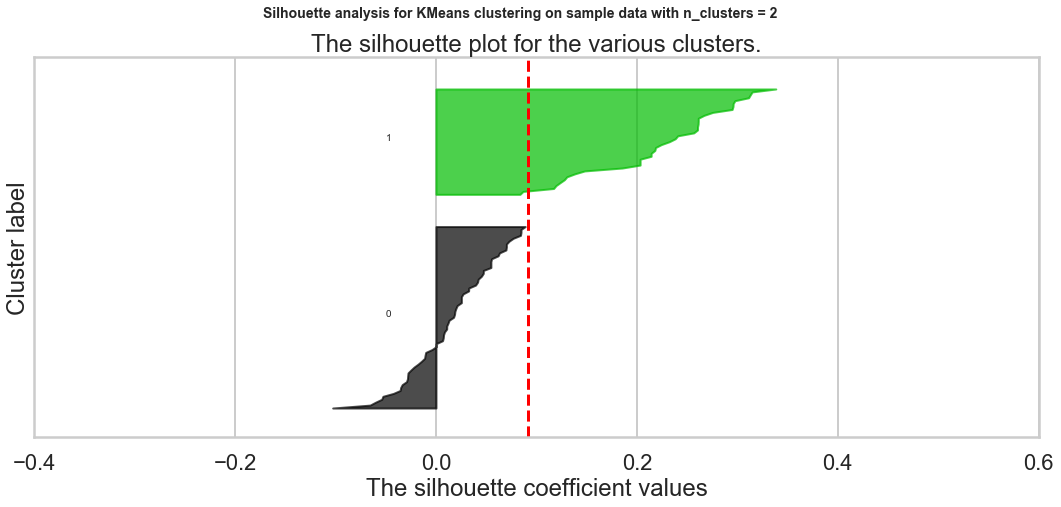

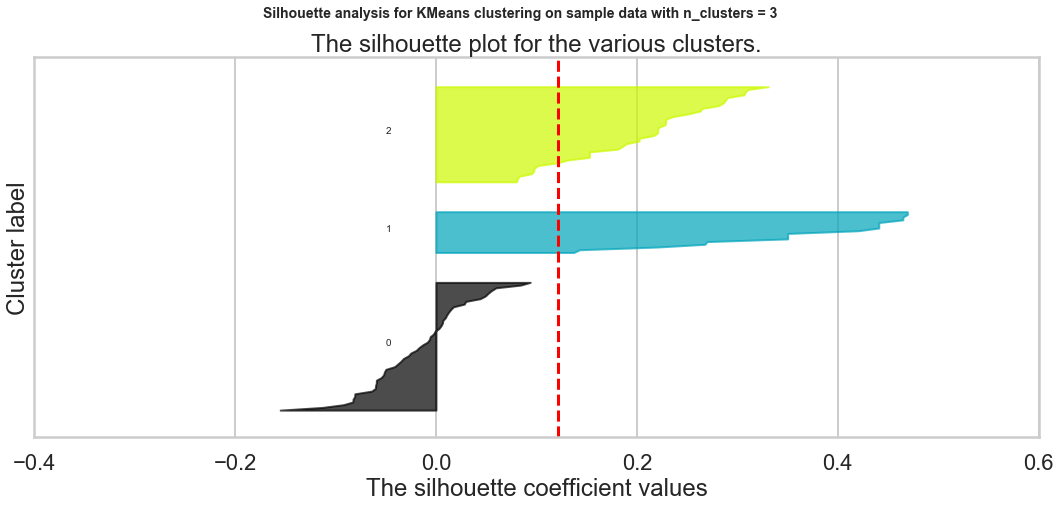

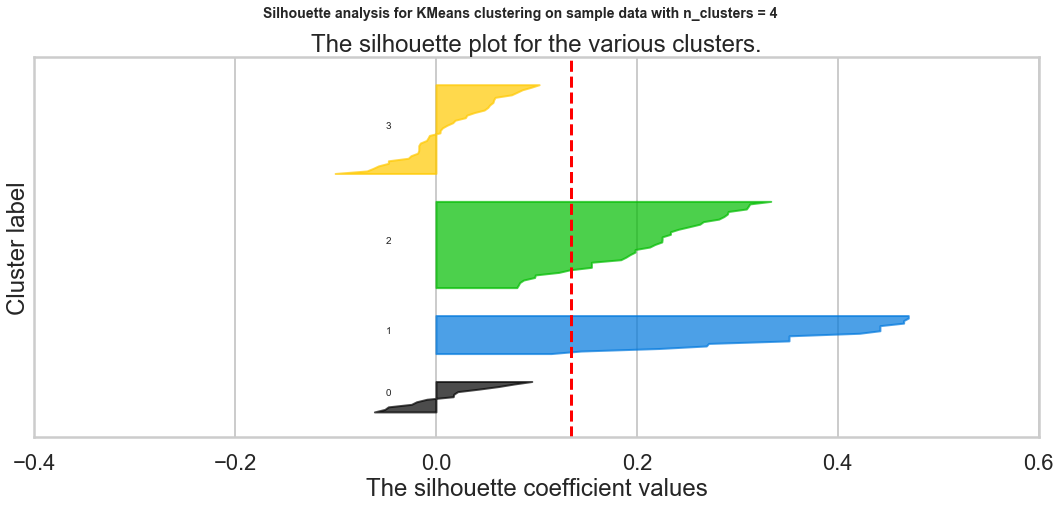

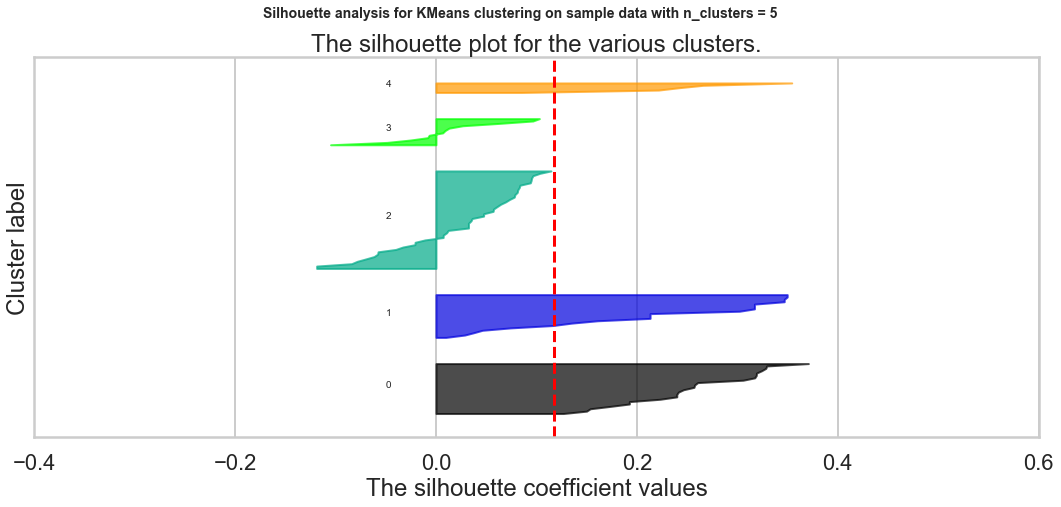

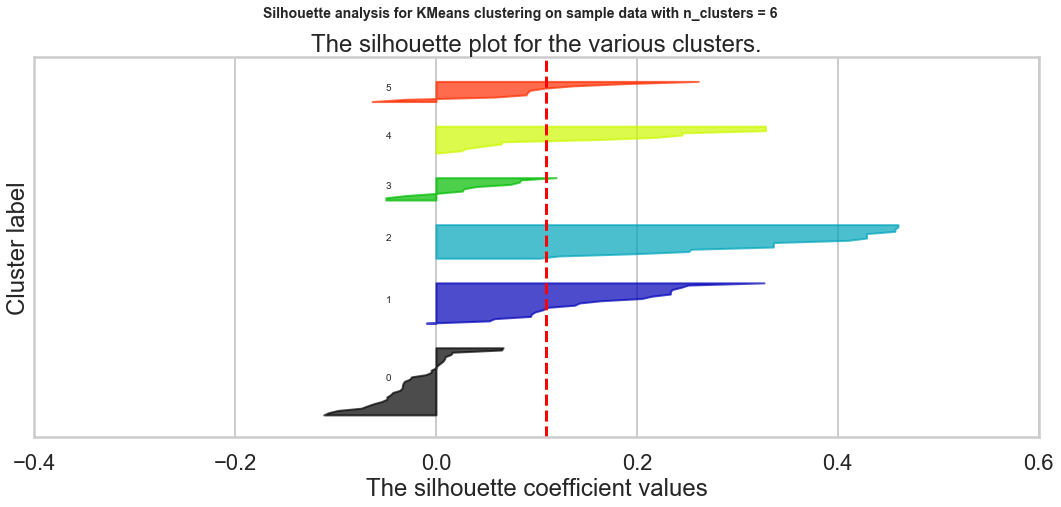

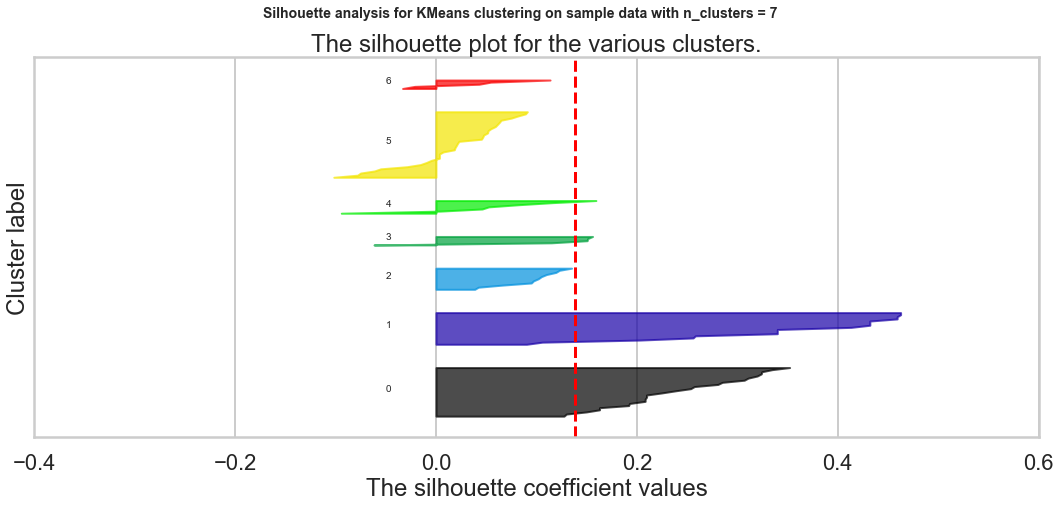

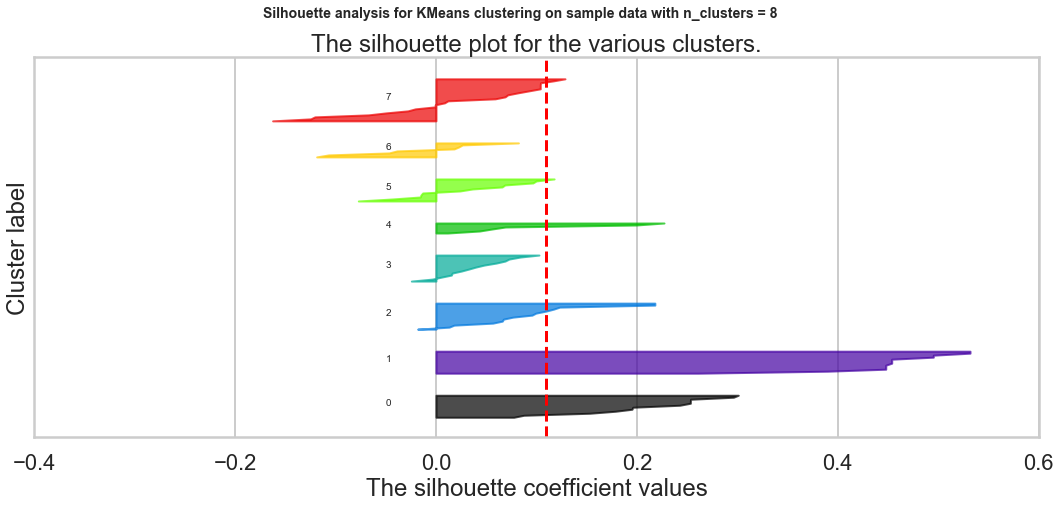

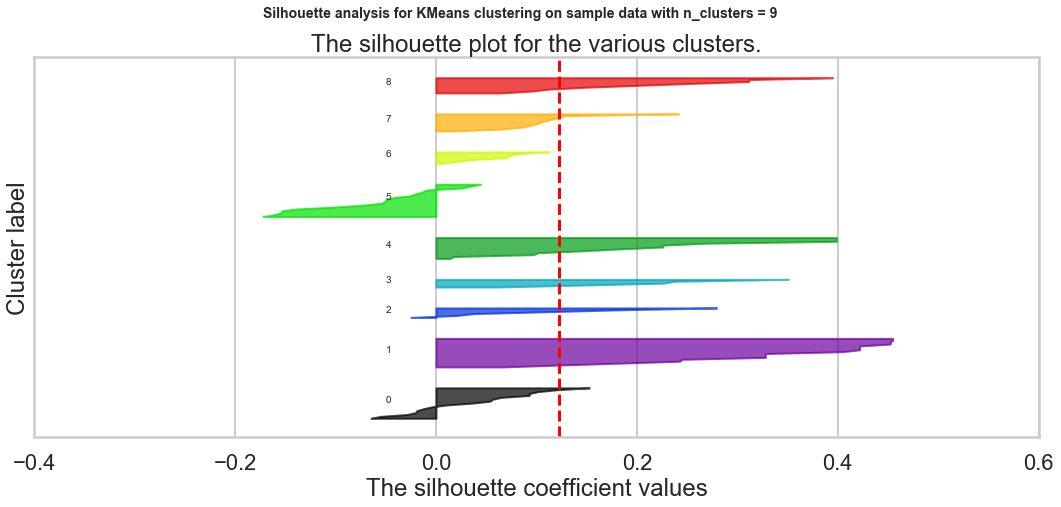

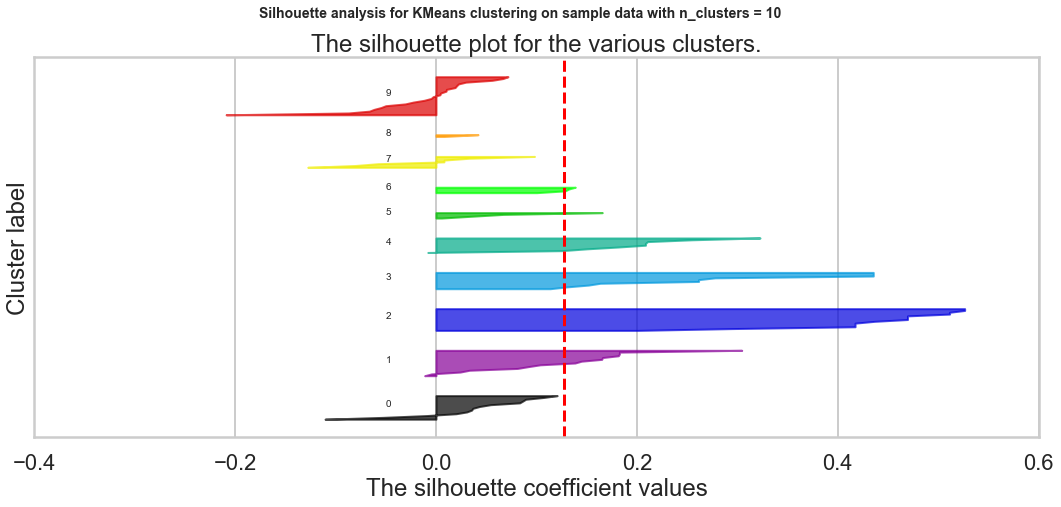

In [31]:
# CODE TAKEN FROM: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# Modified by Andrew Harris as per the comments " # AJH:..." on each line as needed. 
#-------------------------------------------------------------------------------------------------

#from sklearn.datasets import make_blobs          # AJH: blobs not required.
#from sklearn.cluster import KMeans               # AJH: already initiated earlier in workbook.

from sklearn.metrics import silhouette_samples, silhouette_score

#import matplotlib.pyplot as plt         # AJH:already initiated earlier in workbook.
import matplotlib.cm as cm
#mport numpy as np                       # AJH: already initiated earlier in workbook.

print(__doc__)

                                         # AJH: blobs not required. 

# Generating the sample data from make_blobs                             
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
#X, y = make_blobs(n_samples=500,
#                  n_features=2,
#                  centers=4,
#                  cluster_std=1,
#                  center_box=(-10.0, 10.0),
#                  shuffle=True,
#                  random_state=0)  # For reproducibility      

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]    # AJH: 7,8,9,10 were added.
avg = np.zeros(shape=(9,1))                        # AJH: added for saving avg. silhouette values.
assignment = np.zeros(shape=(9,100))               # AJH: added for saving cluster labels.

for ff,n_clusters in enumerate(range_n_clusters):
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()                      # AJH: scatter plot of clusters removed as not required.
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.4, 0.6])                                    # AJH: range adjusted for my data.  
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])       # AJH: x_cols. 

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)    # AJH: Random State is now 0.
    cluster_labels = clusterer.fit_predict(x_cols)               # AJH: x_cols.
    assignment[ff] = cluster_labels                              # AJH: added by Andrew.  
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)    # AJH: x_cols
    avg[ff]=silhouette_avg                                       # AJH: added by Andrew.      
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)  # AJH: x_cols.
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.4,-0.2, 0, 0.2, 0.4, 0.6])            # AJH: scale adjusted for my data

    
    # AJH: Scatter plot of clusters removed. 
    
    # 2nd Plot showing the actual clusters formed      
    #colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    #ax2.scatter(x_cols[:, 0], x_cols[:, 1], marker='.', s=30, lw=0, alpha=0.7,    # AJH: x_cols
    #            c=colors, edgecolor='k')

    # Labeling the clusters
    #centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    #ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
    #            c="white", alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(centers):
    #    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
    #                s=50, edgecolor='k')

    #ax2.set_title("The visualization of the clustered data.")
    #ax2.set_xlabel("Feature space for the 1st feature")
    #ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()



Text(0, 0.5, 'avg silhouette_score')

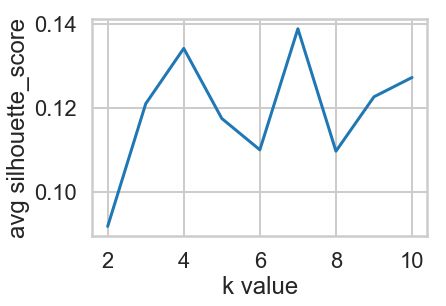

In [32]:
plt.plot(range_n_clusters,avg)
plt.xlabel('k value')
plt.ylabel('avg silhouette_score')

In [33]:
# When K = 7, the average silhouette score is maximized. When using the Elbow sum of squares method
# the K value was 3. 

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
XYcoor = pca.fit_transform(x_cols)
pca.explained_variance_ratio_

array([0.14386393, 0.10800289])

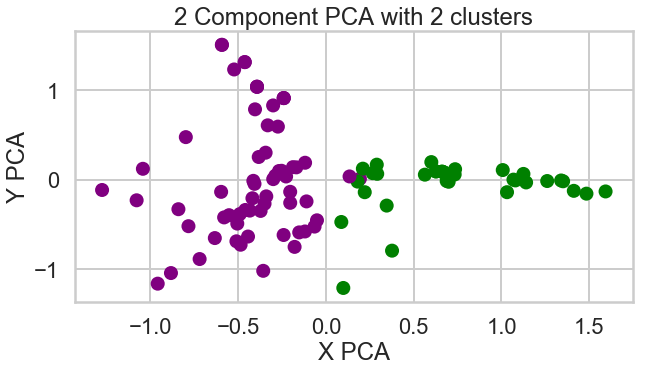

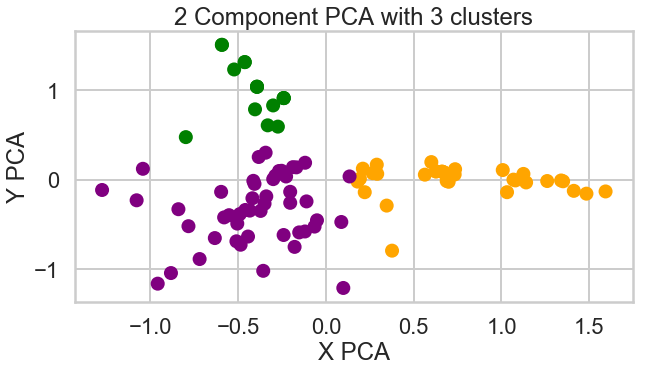

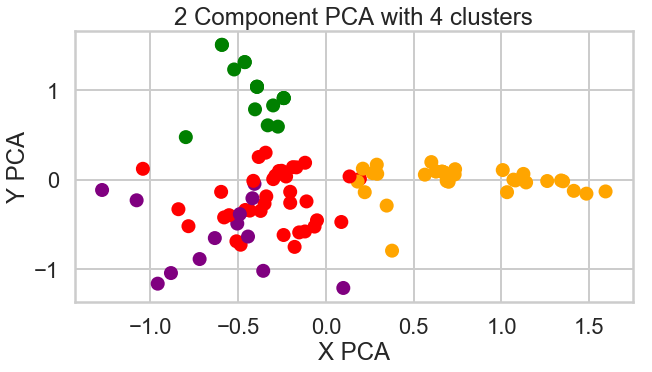

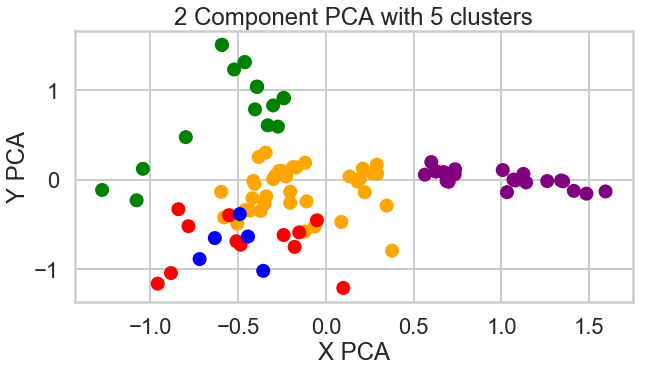

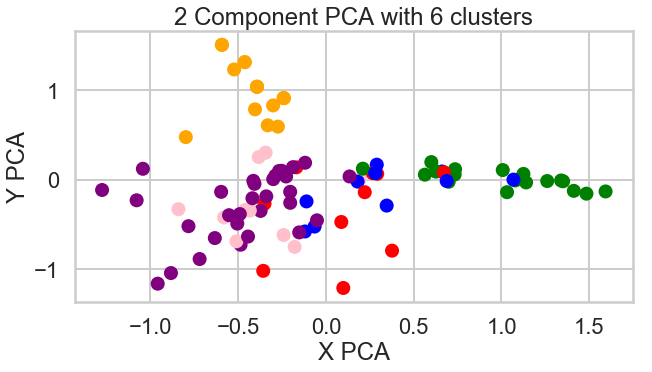

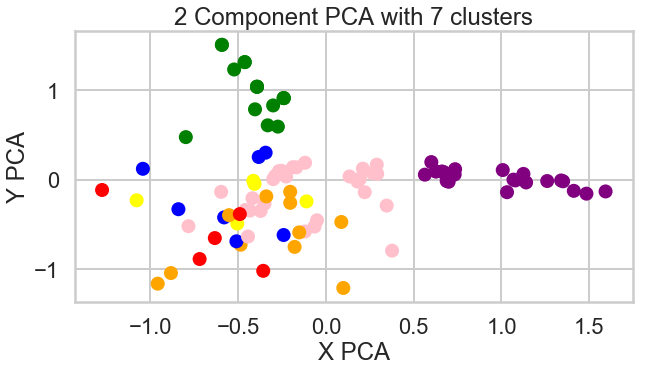

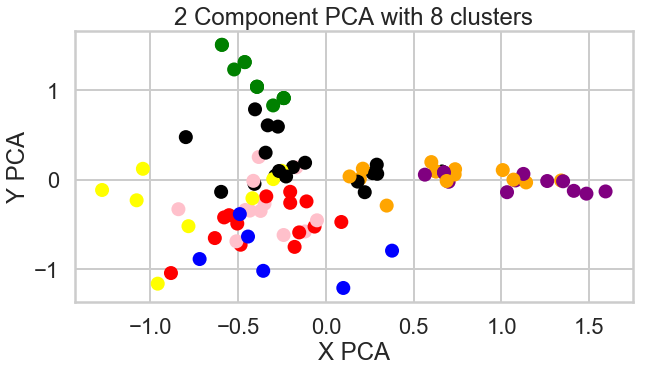

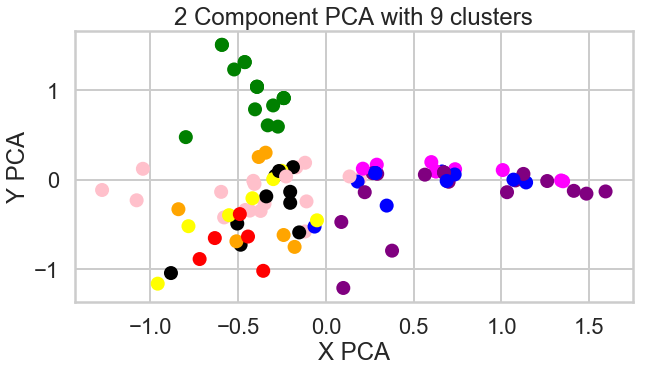

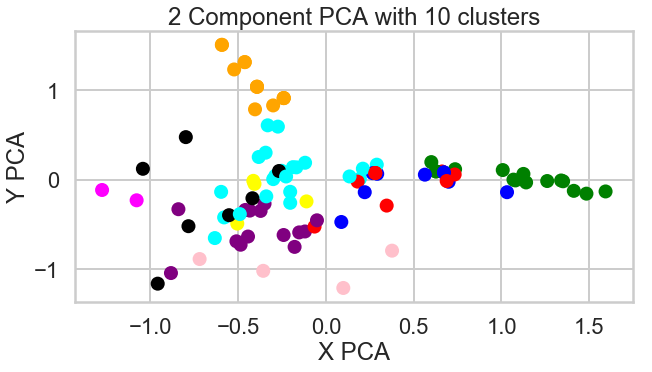

In [35]:
clusternum = np.zeros(shape=(0,100))  

color_dict = dict({0.0:'purple', 1.0 :'green', 2.0: 'orange', 3.0: 'red',4.0: 'blue',5.0: 'pink',6.0:'yellow',7.0:'black',
                  8.0:'magenta',9.0:'cyan'})

for i,j in enumerate(assignment):
    fig, ax1 = plt.subplots()                      
    fig.set_size_inches(10, 5)
    clusternum=assignment[i]
    clusternum = pd.DataFrame(clusternum)
    clusternum.columns=['cluster']
    XYcoor=pd.DataFrame(XYcoor)
    names=df_trans_pivot.reset_index()
    names=names['customer_name']
    names=pd.concat([names,clusternum,XYcoor], axis=1)
    names.columns=['customer_name', 'cluster', 'X PCA', 'Y PCA']
    names["cluster"] = names["cluster"].map(color_dict)
    plt.scatter(names['X PCA'],names['Y PCA'],c=names['cluster'])
    ax1.set_title("2 Component PCA with %d clusters" %range_n_clusters[i])
    ax1.set_xlabel("X PCA")
    ax1.set_ylabel("Y PCA")
    

In [34]:
# How do the clusters look? Based on what you see, what seems to be the best value for K? Moreover, which method of choosing 
# K seems to have produced the optimal result visually?

# K = 2 and K = 3 have clusters which do not overlap. K=4 through K=9 have increasing amounts of overlap as K is increased.
# From these plots, it looks like K =3 is the best value for K. This result was also obtained using the The Elbow 
# Sum-of-Squares Method and produces the optimal result visually.


In [35]:
#Exercise: Now look at both the original raw data about the offers and transactions and look at the fitted clusters. 
#Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine 
#variants or something else interesting?


In [36]:
# Creation of Data Frame with the K=3 cluster assignments.

assessor=pd.DataFrame(x_cols)
assessor.columns=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]
clusters=pd.DataFrame(assignment[1])
clusters.columns=['clusters']
assessor = pd.concat([assessor, clusters], axis=1, join_axes=[assessor.index])
thenames=df_trans_pivot.reset_index()
thenames=thenames['customer_name']
thenames=pd.DataFrame(thenames)
assessor = pd.concat([assessor, thenames], axis=1, join_axes=[assessor.index])
assessor=assessor.set_index(assessor['customer_name'])
assessor=assessor.drop(['customer_name'],axis=1)

In [37]:
# Split previous data frame into a data frame for each cluster.  

cluster0 = assessor[assessor['clusters']==0]
cluster1 = assessor[assessor['clusters']==1]
cluster2 = assessor[assessor['clusters']==2]

cluster0=cluster0.drop(['clusters'],axis=1)
cluster1=cluster1.drop(['clusters'],axis=1)
cluster2=cluster2.drop(['clusters'],axis=1)

In [38]:
# ANALYSIS OF CLUSTER 0 - assessment of offers represented in the cluster

In [39]:
cluster0T=cluster0.T
cluster0T['total']=cluster0T.sum(axis=1)
cluster0Tbuy=cluster0T['total']
cluster0Tbuy=cluster0Tbuy[cluster0Tbuy!=0]
cluster0Tbuy=pd.DataFrame(cluster0Tbuy)

In [40]:
cluster0Tbuy=cluster0Tbuy.reset_index()
cluster0Tbuy['newindex']=cluster0Tbuy['index']-1
cluster0Tbuy.set_index('newindex',inplace=True)
cluster0Tbuy.columns=['c_offer_id','total']
tablec0=pd.concat([cluster0Tbuy, df_offers], axis=1, join_axes=[cluster0Tbuy.index])
tablec0=tablec0.drop('c_offer_id',axis=1)
tablec0

,total,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
newindex,,,,,,,,
0,9.0,1,January,Malbec,72,56,France,False
1,4.0,2,January,Pinot Noir,72,17,France,False
2,4.0,3,February,Espumante,144,32,Oregon,True
3,12.0,4,February,Champagne,72,48,France,True
4,4.0,5,February,Cabernet Sauvignon,144,44,New Zealand,True
5,11.0,6,March,Prosecco,144,86,Chile,False
6,3.0,7,March,Prosecco,6,40,Australia,True
7,3.0,8,March,Espumante,6,45,South Africa,False
8,10.0,9,April,Chardonnay,144,57,Chile,False


In [41]:
# From visual inspection of the above output, offers 13, 17 and 24 are not present.

# Generate a table of the offer_ids that are not in this cluster.

omitted=df_offers[df_offers['offer_id'].isin([13,17,24])]
omitted

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
12,13,May,Merlot,6,43,Chile,False
16,17,July,Pinot Noir,12,47,Germany,False
23,24,September,Pinot Noir,6,34,Italy,False


In [42]:
# Search to see if the offer_id "varietal/origin" combinations in the ommitted offer_ids were purchased under a different 
# offer id.

omittedvarietal=omitted['varietal'].tolist()
omittedorigin=omitted['origin'].tolist()

for x in range(3):
    print(tablec0[(tablec0['varietal'] == omittedvarietal[x]) & (tablec0['origin'] == omittedorigin[x])])

          total  offer_id campaign varietal  min_qty  discount origin  \
newindex                                                                
13          9.0        14     June   Merlot       72        64  Chile   

          past_peak  
newindex             
13            False  
Empty DataFrame
Columns: [total, offer_id, campaign, varietal, min_qty, discount, origin, past_peak]
Index: []
Empty DataFrame
Columns: [total, offer_id, campaign, varietal, min_qty, discount, origin, past_peak]
Index: []


In [43]:
# Initial Observations for Cluster 0

# campaign - all months present
# varietal - all varieties present
# min_qty - all values present
# discount - the values of 43,47,34 which correspond to ids 13, 17 and 24 are not present. 
# origin - all values present.
# past_peak - true and false

# only missing offer ids are 13,17,24. Only the merlot/Chile combination of offer_id = 13 was purchased by this group via
# a different offer id.

# Customers in this cluster didn't purchase pinot noir from Germany or Italy.

# This cluster appears to be a "dumping ground" for customers who didn't fit into the other two clusters. The other two clusters
# will be investigated before any further investigation is performed on this cluster.

In [44]:
# ANALYSIS of CLUSTER 1 - assessment of offers represented in the cluster

In [45]:
cluster1T=cluster1.T
cluster1T['total']=cluster1T.sum(axis=1)
cluster1Tbuy=cluster1T['total']
cluster1Tbuy=cluster1Tbuy[cluster1Tbuy!=0]
cluster1Tbuy=pd.DataFrame(cluster1Tbuy)

In [46]:
cluster1Tbuy=cluster1Tbuy.reset_index()
cluster1Tbuy['newindex']=cluster1Tbuy['index']-1
cluster1Tbuy.set_index('newindex',inplace=True)
cluster1Tbuy.columns=['c_offer_id','total']
tablec1=pd.concat([cluster1Tbuy, df_offers], axis=1, join_axes=[cluster1Tbuy.index])
tablec1=tablec1.drop('c_offer_id',axis=1)
tablec1

,total,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
newindex,,,,,,,,
0,1.0,1,January,Malbec,72,56,France,False
1,6.0,2,January,Pinot Noir,72,17,France,False
9,1.0,10,April,Prosecco,72,52,California,False
11,1.0,12,May,Prosecco,72,83,Australia,False
15,1.0,16,June,Merlot,72,88,California,False
16,7.0,17,July,Pinot Noir,12,47,Germany,False
22,1.0,23,September,Chardonnay,144,39,South Africa,False
23,12.0,24,September,Pinot Noir,6,34,Italy,False
25,12.0,26,October,Pinot Noir,144,83,Australia,False


In [47]:
# Identify which of the values are present in each column for cluster 1.

titles=['campaign','varietal','min_qty','discount','origin','past_peak']
for x in titles:
    print( tablec1[x].unique())

['January' 'April' 'May' 'June' 'July' 'September' 'October']
['Malbec' 'Pinot Noir' 'Prosecco' 'Merlot' 'Chardonnay' 'Champagne']
[ 72  12 144   6]
[56 17 52 83 88 47 39 34]
['France' 'California' 'Australia' 'Germany' 'South Africa' 'Italy'
 'New Zealand']
[False]


In [48]:
# Identify which of the values are NOT present in each column for cluster 1.

clust1dict=tablec1.to_dict(orient='list')
CC=np.logical_not(df_offers.isin(clust1dict))
Notwanted=df_offers[CC]
Notwanted=Notwanted.fillna(method='bfill')
for x in titles:
    print( Notwanted[x].unique())    

['February' 'March' 'August' 'November' 'December']
['Espumante' 'Cabernet Sauvignon' 'Pinot Grigio']
[nan]
[32. 48. 44. 86. 40. 45. 57. 85. 43. 64. 19. 50. 66. 82. 63. 59. 87. 54.
 89.]
['Oregon' 'Chile' nan]
[1.]


In [49]:
# Initial Observations:

# campaign - no feb,mar,august,nov,dec   
# varietal - no Cabernet Sauvignon, Espumante, Pinot Grigio 
# min_qty - all accounted for.
# discount - no strong relationship. discount values from low, mid and high ends of the range are present. 
# origin -  no Chile, no oregon 
# past_peak - always false

# Customers in this cluster did not order wine that is past_peak = TRUE. Further investigation will be performed below.

In [50]:
# df_offers dataframe is reduced by only showing offers where past_peak = FALSE
# The "fresh" data frame shows that offers were made for wine from Chile and Oregon, but customers in the cluster didn't order it.

df_offers_fresh=df_offers[df_offers['past_peak'] == False]
df_offers_fresh.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
5,6,March,Prosecco,144,86,Chile,False
7,8,March,Espumante,6,45,South Africa,False
8,9,April,Chardonnay,144,57,Chile,False


In [51]:
# Isolate the months for which the customers in this cluster didn't place orders.

df_offers_fresh=df_offers_fresh[df_offers_fresh['campaign'].isin(['February', 'March', 'August', 'November', 'December'])]

In [52]:
df_offers_fresh

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
5,6,March,Prosecco,144,86,Chile,False
7,8,March,Espumante,6,45,South Africa,False
19,20,August,Cabernet Sauvignon,72,82,Italy,False
20,21,August,Champagne,12,50,California,False
21,22,August,Champagne,72,63,France,False
28,29,November,Pinot Grigio,6,87,France,False
29,30,December,Malbec,6,54,France,False
30,31,December,Champagne,72,89,France,False


In [53]:
# Test the varietal/origin combinations that were purchased by the cluster to see if offers containing them were made during
# the months that the customers in the clusters didn't purchase.
# As per the output, only Malbec/France was the only combo offered that was purchased by this cluster during a different month

listvarietal=tablec1['varietal'].tolist()
listcountry=tablec1['origin'].tolist()
for x in range(10):
    print(df_offers_fresh[(df_offers_fresh['varietal'] == listvarietal[x] ) & (df_offers_fresh['origin'] == listcountry[x]) ])
    


    offer_id  campaign varietal  min_qty  discount  origin  past_peak
29        30  December   Malbec        6        54  France      False
Empty DataFrame
Columns: [offer_id, campaign, varietal, min_qty, discount, origin, past_peak]
Index: []
Empty DataFrame
Columns: [offer_id, campaign, varietal, min_qty, discount, origin, past_peak]
Index: []
Empty DataFrame
Columns: [offer_id, campaign, varietal, min_qty, discount, origin, past_peak]
Index: []
Empty DataFrame
Columns: [offer_id, campaign, varietal, min_qty, discount, origin, past_peak]
Index: []
Empty DataFrame
Columns: [offer_id, campaign, varietal, min_qty, discount, origin, past_peak]
Index: []
Empty DataFrame
Columns: [offer_id, campaign, varietal, min_qty, discount, origin, past_peak]
Index: []
Empty DataFrame
Columns: [offer_id, campaign, varietal, min_qty, discount, origin, past_peak]
Index: []
Empty DataFrame
Columns: [offer_id, campaign, varietal, min_qty, discount, origin, past_peak]
Index: []
Empty DataFrame
Columns: [of

In [ ]:
# Analysis of Cluster 2 - assessment of offers represented in the cluster.

In [54]:
cluster2T=cluster2.T
cluster2T['total']=cluster2T.sum(axis=1)
cluster2Tbuy=cluster2T['total']
cluster2Tbuy=cluster2Tbuy[cluster2Tbuy!=0]
cluster2Tbuy=pd.DataFrame(cluster2Tbuy)

In [55]:
cluster2Tbuy=cluster2Tbuy.reset_index()
cluster2Tbuy['newindex']=cluster2Tbuy['index']-1
cluster2Tbuy.set_index('newindex',inplace=True)
cluster2Tbuy.columns=['c_offer_id','total']
tablec2=pd.concat([cluster2Tbuy, df_offers], axis=1, join_axes=[cluster2Tbuy.index])
tablec2=tablec2.drop('c_offer_id',axis=1)
tablec2

,total,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
newindex,,,,,,,,
2,2.0,3,February,Espumante,144,32,Oregon,True
5,1.0,6,March,Prosecco,144,86,Chile,False
6,16.0,7,March,Prosecco,6,40,Australia,True
7,17.0,8,March,Espumante,6,45,South Africa,False
9,2.0,10,April,Prosecco,72,52,California,False
10,1.0,11,May,Champagne,72,85,France,False
11,1.0,12,May,Prosecco,72,83,Australia,False
12,6.0,13,May,Merlot,6,43,Chile,False
17,13.0,18,July,Espumante,6,50,Oregon,False


In [56]:
# Identify which of the values are present in each column for cluster 2.

for x in titles:
    print( tablec2[x].unique())

['February' 'March' 'April' 'May' 'July' 'August' 'October' 'November'
 'December']
['Espumante' 'Prosecco' 'Champagne' 'Merlot' 'Cabernet Sauvignon'
 'Pinot Grigio' 'Malbec']
[144   6  72  12]
[32 86 40 45 52 85 83 43 50 66 63 88 56 87 54]
['Oregon' 'Chile' 'Australia' 'South Africa' 'California' 'France'
 'Germany' 'New Zealand']
[ True False]


In [57]:
# Identify which of the values are not present in each column for cluster 2.

clust2dict=tablec2.to_dict(orient='list')
CC2=np.logical_not(df_offers.isin(clust2dict))
Notwanted2=df_offers[CC2]
Notwanted2=Notwanted2.fillna(method='bfill')
for x in titles:
    print( Notwanted2[x].unique())

['January' 'June' 'September' nan]
['Pinot Noir' 'Chardonnay' nan]
[nan]
[17. 48. 44. 57. 64. 19. 47. 82. 39. 34. 59. 89. nan]
['Italy' nan]
[nan]


In [ ]:
# Initial Observations

# campaign - no january,june, september
# varietal - no Chardonnay, Pinot Noir  
# min_qty - all accounted for.
# discount - no strong relationship. discount values from low, mid and high ends of the range are present. 
# origin -  no italy.
# past_peak - true and false

In [58]:
# Isolate the months for which the customers in this cluster didn't place orders.

df_offers_C2=df_offers[df_offers['campaign'].isin(['January', 'June', 'September'])]
df_offers_C2

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
13,14,June,Merlot,72,64,Chile,False
14,15,June,Cabernet Sauvignon,144,19,Italy,False
15,16,June,Merlot,72,88,California,False
22,23,September,Chardonnay,144,39,South Africa,False
23,24,September,Pinot Noir,6,34,Italy,False


In [59]:
# Test the varietal/origin combinations that were purchased by the cluster to see if offers containing them were made during
# the months that the customers in the clusters didn't purchase.

# As per the output, only Malbec/France and Merlot/Chile were the only combos offered that were purchased by this cluster 
# during a different month. Both were offered in much smaller quantities during the months the purchases were made.

listvarietal1=tablec2['varietal'].tolist()
listcountry1=tablec2['origin'].tolist()
for x in range(16):
    print(df_offers_C2[(df_offers_C2['varietal'] == listvarietal1[x] ) & (df_offers_C2['origin'] == listcountry1[x])])

Empty DataFrame
Columns: [offer_id, campaign, varietal, min_qty, discount, origin, past_peak]
Index: []
Empty DataFrame
Columns: [offer_id, campaign, varietal, min_qty, discount, origin, past_peak]
Index: []
Empty DataFrame
Columns: [offer_id, campaign, varietal, min_qty, discount, origin, past_peak]
Index: []
Empty DataFrame
Columns: [offer_id, campaign, varietal, min_qty, discount, origin, past_peak]
Index: []
Empty DataFrame
Columns: [offer_id, campaign, varietal, min_qty, discount, origin, past_peak]
Index: []
Empty DataFrame
Columns: [offer_id, campaign, varietal, min_qty, discount, origin, past_peak]
Index: []
Empty DataFrame
Columns: [offer_id, campaign, varietal, min_qty, discount, origin, past_peak]
Index: []
    offer_id campaign varietal  min_qty  discount origin  past_peak
13        14     June   Merlot       72        64  Chile      False
Empty DataFrame
Columns: [offer_id, campaign, varietal, min_qty, discount, origin, past_peak]
Index: []
Empty DataFrame
Columns: [offer_

In [ ]:
# Assessment of Common purchases within clusters.

In [ ]:
# Cluster 0

In [61]:
table0n = cluster0.loc[:, (cluster0 != 0).any(axis=0)]
table0n.head()

,1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,18,19,20,21,22,23,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Barnes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Brooks,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Butler,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


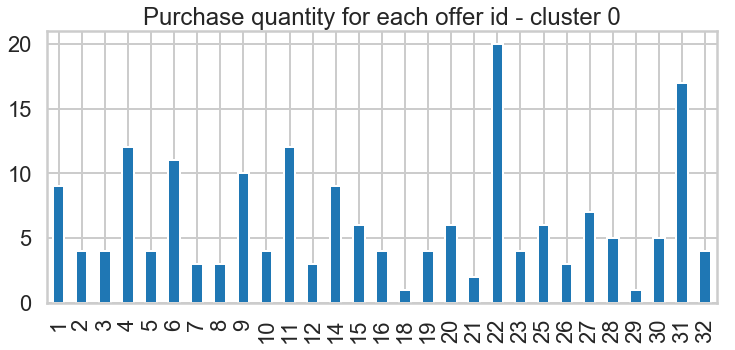

In [373]:
howmuch0=table0n.apply(pd.Series.sum)
howmuch0.plot(kind='bar',figsize=(12,5),title = 'Purchase quantity for each offer id - cluster 0')


In [ ]:
# From the bar chart above, it is clear that no single offer was accepted by more than 20 of the customers in the 
# 48 customer cluster. 

In [362]:
df_offers[df_offers['offer_id']==22]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
21,22,August,Champagne,72,63,France,False


In [ ]:
#Cluster 1

In [64]:
table1n = cluster1.loc[:, (cluster1 != 0).any(axis=0)]
table1n

,1,2,10,12,16,17,23,24,26,27
customer_name,,,,,,,,,,
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
Bell,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
Campbell,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
Cook,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
Cox,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
Flores,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
Gray,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
Jenkins,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
Johnson,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


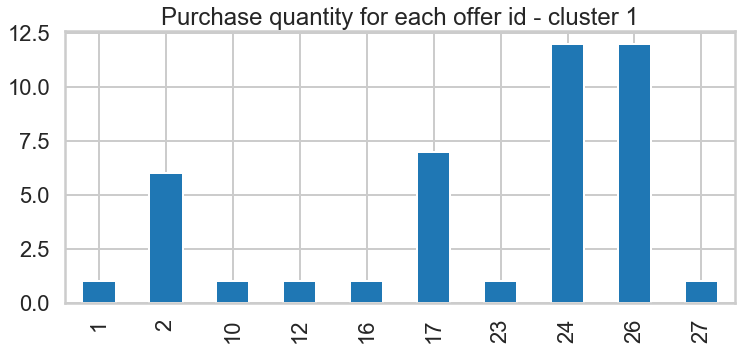

In [374]:
howmuch1=table1n.apply(pd.Series.sum)
howmuch1.plot(kind='bar',figsize=(12,5),title = 'Purchase quantity for each offer id - cluster 1')

In [ ]:
# From the bar chart above, it is clear that offer 24 and 26 were both accepted by 12 of the customers in this 
# 16 customer cluster. Looking back at the print out of table1n, it is visually observed that all customers in the cluster
# accepted offer 24 or offer 26 or both of offer 24 and 26.

In [363]:
df_offers[df_offers['offer_id']==24]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
23,24,September,Pinot Noir,6,34,Italy,False


In [364]:
df_offers[df_offers['offer_id']==26]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
25,26,October,Pinot Noir,144,83,Australia,False


In [365]:
df_offers[df_offers['offer_id']==17]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
16,17,July,Pinot Noir,12,47,Germany,False


In [ ]:
# Cluster 2

In [66]:
table2n = cluster2.loc[:, (cluster2 != 0).any(axis=0)]
table2n.head()

,3,6,7,8,10,11,12,13,18,19,21,22,27,28,29,30
customer_name,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
Bailey,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Bennett,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Brown,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
Carter,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


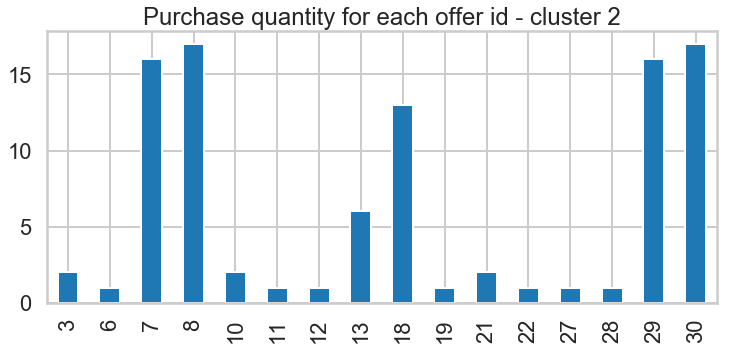

In [375]:
howmuch2=table2n.apply(pd.Series.sum)
howmuch2.plot(kind='bar',figsize=(12,5),title = 'Purchase quantity for each offer id - cluster 2')

In [ ]:
#From the bar chart above, it is clear that offer 7, 8, 29 and 30 all accepted by 16 or more of the customers in this 
# 36 customer cluster.

In [366]:
df_offers[df_offers['offer_id']==7]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
6,7,March,Prosecco,6,40,Australia,True


In [367]:
df_offers[df_offers['offer_id']==8]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
7,8,March,Espumante,6,45,South Africa,False


In [368]:
df_offers[df_offers['offer_id']==29]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
28,29,November,Pinot Grigio,6,87,France,False


In [369]:
df_offers[df_offers['offer_id']==30]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
29,30,December,Malbec,6,54,France,False


In [990]:
# Test to see how many customers in the cluster purchased 1 or more of 7,8,29,30
# 35 of 36 customers purchased at least one of 7,8,29,30.

table2nreduced=table2n.drop([3,6,10,11,12,13,18,19,21,22,27,28,],axis=1)
table2nreduced[(table2nreduced[7]==0)&(table2nreduced[8]==0)&(table2nreduced[29]==0)&(table2nreduced[30]==0)]


,7,8,29,30
customer_name,,,,
Ross,0.0,0.0,0.0,0.0


In [ ]:
# Fina Data Story for the clusters:

# Cluster 1 consists of 16 customers who as a group:
#     1. do not purchase wine that is past peak.
#     2. do not purchase wine from Chile or Oregon. 
#     3. do not purchase Cabernet Sauvignon, Espumante or Pinot Grigio varietal from any country.
#     4. have purchased all available Pinot Noir (Italy, Australia, France, Germany), and the following: 
#        Prosecco/(California,Australia), Merlot/California, Chardonnay/South Africa, 
#        Champagne/ New Zealand, Malbec/France.
#     5. During the months that these customers didn't respond to offers ('February' 'March' 'August' 'November' 'December') 
#        only one of the varietal/county combos that they had purchased was offered (Malbec/France in December).
#     6. All 16 customers in the cluster responded to either or both of offer id 24 and 26, Pinot Noir/ Italy and Pinot Noir/
#        Australia. 
#
#                   
# Cluster 2 consists of 36 customers who as a group: 
#     1. purchase wine that is past peak or not past peak.
#     2. do not purchase wine from Italy.
#     3. do not purchase Chardonnay or Pinot Noir from any country.
#     4. have purchased Champagne/(France, Germany,California,New Zealand), Prosecco/(Australia, Chile, California)
#        Espumante/(South Africa, Oregon), Cabernet Sauvignon/France, Pinot Grigio/France, Malbec/France, Merlot/Chile.
#     5. During the months that these customers didn't respond to offers ('January' 'June' 'September') 
#        only two of the varietal/county combos that they had purchased were offered (Malbec/France in January and
#        Merlot/Chile in June
#     6. 35 of 36 customers in this group purchased one or more of offer_id 7, 8, 29 and 30 (Prosecco/Australia (16),
#        Espumante/South Africa (17), Pinot Grigio/France (16), Malbec/France (17)).
#
# Cluster 0 consists of the remaining 48 customers who as a group:
#     1. purchase wine that is past peak or not past peak.
#     2. purchase wine from all countries.
#     3. purchased wine of all varietals.
#     4. The only combinations this group has not purchased are Pinot Noir from both Germany and Italy.
#     5. purchased wine during every month.
#     6. This group appears to be the customers who don't fit into the other two groups. There do not seem to be any
#        strong trends like in the other two clusters. 
#
# Conlusions:      
#     Cluster 1 are the Pinot Noir purchasers who never purchase Espumante or Pinot Grigio.
#     Cluster 2 are the Prosecco/Espumante/Pinot Grigio/Malbec purchasers who purchase drink Pinot Noir.
#     Cluster 0 are the wine purchasers who do not fit into cluster 1 or 2 when dividing customers into3 clusters.
#     

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [37]:
#your turn
# Initialize a new PCA model with a default number of components.
#import sklearn.decomposition
#pca = sklearn.decomposition.PCA()
#pca.fit(X)

ncomp = range(1,33)
varcol= np.zeros(shape=(len(ncomp),1))
delta=np.zeros(shape=(len(ncomp),1))

for i,j in enumerate(ncomp):
    pca = PCA(n_components= ncomp[i])
    XYZ = pca.fit_transform(x_cols)
    var=pca.explained_variance_
    varcol[i]=np.sum(var)


([<matplotlib.axis.XTick at 0x23d51b28630>,
 <a list of 6 Text xticklabel objects>)

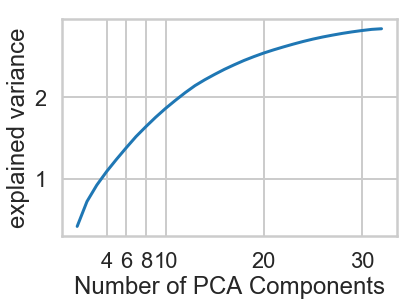

In [38]:
plt.plot(ncomp,varcol)
plt.xlabel('Number of PCA Components')
plt.ylabel('explained variance')
plt.xticks([4,6,8,10,20,30])

Text(0, 0.5, 'explained variance')

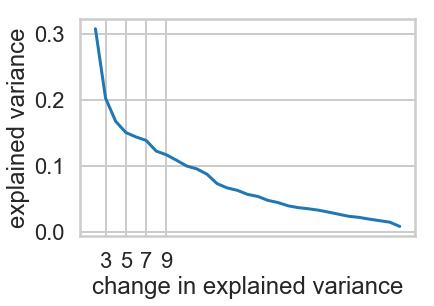

In [39]:
# its hard to find an "elbow" on the graph above, so I will plot the incremental change in explained variance as K increases.

calc1=np.delete(varcol,0)
calc2=np.delete(varcol,31)
delta=calc1-calc2
ncomp1=np.delete(ncomp,0)
plt.plot(ncomp1,delta)
plt.xticks([3, 5, 7, 9]) 
plt.xlabel ('change in explained variance')
plt.ylabel('explained variance')

In [40]:
# PCA Component = 6 is the elbow point as it corresponds with the 5th change on the plot (6-5).
#6 dimensions appears to be optimal because after 6 the incremental gains in explained variance decrease substantially.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [41]:
# Affinity Propagation

from sklearn.cluster import AffinityPropagation
affprop = AffinityPropagation().fit_predict(x_cols)
print(affprop)
bins=np.unique(affprop,return_counts=True)
print(bins)

[ 0 10  6  3  3 12  6  7  4  2  9 13  2 12  4  6  3  6  0  1  2  7  4  9
  6 10 11  4 12 13  3  7  4  8  0  5  4  2  4  5  6  6  7 12  0  8  2  3
 10 13  1 12 13  6  7  7  6  3  0  7 12  7 12  0  0 13  6 11  9 10 11 10
  8  3 12  3 13  3  3 13 11 10 11 13  2  5  0 10 10  7 12  0  7  3  1 12
  7 12  8 12]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
      dtype=int64), array([ 9,  3,  6, 11,  7,  3, 10, 11,  4,  3,  8,  5, 12,  8],
      dtype=int64))


In [42]:
# Affinity Propagation chooses the number of clusters rather than having the user specify the number of clusters.
# Using the default damping factor of 0.5 gives 14 clusters.
# When damping factor is set to 0.8 through 0.97 there are only 11 clusters.
# These numbers of clusters are higher than the number of clusters determined during the earlier exercises in this assignment.
# This algorithm is likely not a good one as it does not agree with number of clusters obtained using other 
# algorithms which were used earlier in the assignment (k=3,6,7).

In [327]:
# Spectral clustering (n_clusters not set, random_state=0). As per outout, it divides into eight clusters.

from sklearn.cluster import SpectralClustering
specclus = SpectralClustering(random_state=0).fit_predict(x_cols)
print(specclus)
bins=np.unique(specclus,return_counts=True)
print(bins)

[0 1 4 5 1 1 4 7 3 5 3 4 5 1 7 4 1 4 5 3 5 7 7 3 7 1 1 1 1 4 5 7 3 2 5 0 3
 5 3 0 4 4 7 1 5 2 5 5 1 3 3 1 1 7 6 7 4 5 0 7 1 7 1 0 0 4 7 1 3 1 1 1 6 5
 1 5 4 6 1 4 1 1 1 4 7 0 5 1 1 7 2 5 1 5 3 1 7 1 2 1]
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 7, 30,  4, 11, 13, 17,  3, 15], dtype=int64))


In [266]:
# Spectral clustering (n_clusters=3, random_state=0)

specclus3 = SpectralClustering(n_clusters=3, random_state=0).fit_predict(x_cols)
print(specclus3)
bins=np.unique(specclus3,return_counts=True)
print(bins)

[2 1 0 2 1 1 0 2 1 2 1 0 2 1 2 0 1 0 2 1 2 1 1 1 0 1 1 1 1 1 2 2 1 1 2 2 1
 2 1 2 0 0 1 1 2 1 2 2 1 1 1 1 1 0 1 2 0 2 2 1 1 1 1 2 2 1 0 1 1 1 1 1 1 2
 1 2 0 1 2 0 1 1 1 0 2 2 2 1 1 1 1 2 1 2 1 1 2 1 1 1]
(array([0, 1, 2]), array([14, 55, 31], dtype=int64))


In [155]:
# Spectral Clustering (n_clusters=6, random_state=0)

specclus6 = SpectralClustering(n_clusters=6, random_state=0).fit_predict(x_cols)
print(specclus6)
bins=np.unique(specclus6,return_counts=True)
print(bins)

[3 5 2 4 5 5 2 1 1 4 5 2 4 5 5 2 5 2 4 5 4 1 1 5 2 5 5 5 5 5 4 1 5 0 4 3 5
 4 5 3 2 2 1 5 4 0 4 4 5 5 5 5 5 2 1 1 2 4 3 1 5 1 5 3 3 5 2 5 5 5 5 5 1 4
 5 4 2 1 3 2 5 5 5 2 4 3 4 5 5 1 0 3 1 4 5 5 1 5 0 5]
(array([0, 1, 2, 3, 4, 5]), array([ 4, 15, 14,  9, 17, 41], dtype=int64))


In [156]:
# Spectral clustering (n_clusters=7, random_state=0)

specclus7 = SpectralClustering(n_clusters=7, random_state=0).fit_predict(x_cols)
print(specclus7)
bins=np.unique(specclus7,return_counts=True)
print(bins)

[4 2 5 0 2 2 5 3 3 0 2 5 0 2 2 5 2 5 0 2 0 3 2 2 6 2 2 2 2 5 0 3 2 1 0 4 2
 0 2 4 5 5 3 2 0 1 0 0 2 2 2 2 2 6 3 3 5 0 4 3 2 3 2 4 4 5 6 2 2 2 2 2 3 0
 2 0 5 3 2 5 2 2 2 5 3 4 0 2 2 3 1 0 2 0 2 2 3 2 1 2]
(array([0, 1, 2, 3, 4, 5, 6]), array([17,  4, 42, 14,  7, 13,  3], dtype=int64))


In [45]:
# Without specifying n_clusters, the number of clusters the data is divided into is 8. 
# specifying the n_neighbors parameter does not change the number of clusters or the number of points in each cluster.

# For the cases of K=3,6,7,8 above, we can see that the first customer is in a different bin number for each K case even though
# the random state is the same for all cases.

In [78]:
# Agglomerative clustering (n_clusters not set). As per the output, it divides into two clusters.

from sklearn.cluster import AgglomerativeClustering
aggclu = AgglomerativeClustering().fit_predict(x_cols)
print(aggclu)
bins=np.unique(aggclu,return_counts=True)
print(bins)

[1 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0
 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1
 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 0]
(array([0, 1], dtype=int64), array([66, 34], dtype=int64))


In [123]:
# Agglomerative clustering 

aggclu3 = AgglomerativeClustering(n_clusters=3).fit_predict(x_cols)
print(aggclu3)
bins=np.unique(aggclu3,return_counts=True)
print(bins)

[1 0 2 1 0 0 2 1 0 1 0 2 1 0 1 2 0 2 1 0 1 1 0 0 2 0 0 0 0 2 1 1 0 0 1 1 0
 1 0 1 2 2 1 0 1 0 1 0 0 0 0 0 2 2 0 1 2 1 1 0 0 1 0 1 1 2 2 0 0 0 0 0 0 1
 0 1 2 0 1 2 0 0 0 2 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 0]
(array([0, 1, 2], dtype=int64), array([49, 34, 17], dtype=int64))


In [81]:
# Agglomerative clustering 

aggclu6 = AgglomerativeClustering(n_clusters=6).fit_predict(x_cols)
print(aggclu6)
bins=np.unique(aggclu6,return_counts=True)
print(bins)

[1 0 2 1 0 0 2 1 4 1 4 2 1 0 1 2 0 2 1 0 1 1 3 4 2 5 0 0 0 2 1 1 4 3 1 1 4
 1 4 1 2 2 1 0 1 3 1 0 0 0 0 0 2 2 3 1 2 1 1 0 0 1 0 1 1 2 2 0 4 0 0 0 3 1
 0 1 2 3 1 2 5 5 0 2 1 1 1 5 0 1 3 1 0 1 0 0 1 0 3 0]
(array([0, 1, 2, 3, 4, 5], dtype=int64), array([30, 34, 17,  8,  7,  4], dtype=int64))


In [82]:
# Agglomerative clustering 

aggclu7 = AgglomerativeClustering(n_clusters=7).fit_predict(x_cols)
print(aggclu7)
bins=np.unique(aggclu7,return_counts=True)
print(bins)

[1 0 2 1 6 6 2 1 4 1 4 2 1 0 1 2 0 2 1 0 1 1 3 4 2 5 0 0 0 2 1 1 4 3 1 1 4
 1 4 1 2 2 1 0 1 3 1 6 0 0 0 6 2 2 3 1 2 1 1 0 6 1 0 1 1 2 2 0 4 0 0 0 3 1
 6 1 2 3 1 2 5 5 0 2 1 1 1 5 0 1 3 1 0 1 0 6 1 6 3 6]
(array([0, 1, 2, 3, 4, 5, 6], dtype=int64), array([21, 34, 17,  8,  7,  4,  9], dtype=int64))


In [ ]:
# For the cases of K=2,3,6,7, above, we can see that the many of the customers stay in the same bin number as the number of 
# clusters changes. looking at the first six customers, we observe that 1 0 2 1 0 0 is the result for k= 3,6 and that 
# 1 0 2 1 6 6 is the result for k =7 and that 1 0 0 1 0 0 is the result for k=2. Thus, a similar structure is being maintained.

In [48]:
# DBSCAN clustering

from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=1, min_samples=3).fit_predict(x_cols)
print(dbscan)
bins=np.unique(dbscan,return_counts=True)
print(bins)

[ 0  2  1  0 -1 -1  1  0 -1  0 -1  1  0 -1 -1  1 -1  1  0 -1  0  0 -1 -1
  1 -1 -1 -1  2 -1  0 -1 -1 -1 -1  3 -1  0 -1  3  1  1  0 -1 -1 -1  0 -1
 -1 -1 -1 -1 -1  1 -1  0  1  0  0 -1  2  0 -1  0  0 -1  1 -1 -1  2 -1  2
 -1  0  2  0  1 -1 -1  1 -1 -1 -1  1  0  3  0 -1 -1  0 -1  0 -1  0 -1 -1
  0 -1 -1 -1]
(array([-1,  0,  1,  2,  3], dtype=int64), array([51, 26, 14,  6,  3], dtype=int64))


In [49]:
# FROM: https://scikit-learn.org/stable/modules/clustering.html#dbscan (Section 2.3.7): 
# "The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic 
# view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped." 

# Based on the "separation" description and the scatter plots generated for 2 component PCA, this clustering algorithm
# is likely not the right choice for this dataset as the clusters were not separated by low density areas.

# With eps = 1, 60 samples are binned as -1 (noisy) and the other 40 are split over 4 clusters [7, 14, 16, 3].
# With eps = 1 and min_samples=3, 51 samples are noisy and the other 49 are split over 4 clusters [26, 14,  6,  3]
# No matter how eps and min_samples are adjusted, roughly half of the data gets binned as -1 (noisy)
# Based on the fact that half of the points get put in a "noisy cluster", I would say that this algorithm is not suitable
# for clustering this dataset.

In [ ]:
# Conclusion:
# Based on the results above, DBSCAN and affinity propagation are unsuitable for use in this dataset. Agglomerative clustering
# and spectral clustering appear to be suitable but spectral clustering changes the cluster number assigned to a given data
# point almost everytime the algorithm is rerun with a different k value but with the random_state fixed. Agglomerative
# clustering appears to be maintaining the cluster numbers assigned to the data but with slight changes as the number of 
# clusters increases. Due to the "consistency" as K changes, I am inclined to believe that agglomerative clustering is the best
# algorithm for this particular dataset.